## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

import re

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file
f = open('complaints-2021-05-14_08_16.json', 'r') # Write the path to your data file and load it

# returns JSON object as
# a dictionary
data = json.load(f)
f.close()
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
df.head()
print("The Shape of the dataset is: ", df.shape)

The Shape of the dataset is:  (78313, 22)


In [4]:
#print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [5]:
#Assign new column names
columns_rename_map = {}
for cols in df.columns:
    columns_rename_map[cols]=cols.replace('_source.', '')
    if columns_rename_map[cols][0] == '_':
        columns_rename_map[cols] = columns_rename_map[cols][1:]

df.rename(columns = columns_rename_map, inplace=True)

print("columns after rename: \n", df.columns)
#df.rename(columns= )

columns after rename: 
 Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')


In [6]:
#Assign nan in place of blanks in the complaints column
df[df['complaint_what_happened'] == ''] = np.nan

In [7]:
#Remove all rows where complaints column is nan
df.dropna(subset=('complaint_what_happened'), inplace=True)

In [8]:
print("Data after Removing Duplicates", df.shape)

Data after Removing Duplicates (21072, 22)


## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [9]:
# Write your function here to clean the text and remove all the unnecessary elements.
import re
def cleanup_column(data):
    "Convert text to lower case, remove text in square braces, remove punctuations, remove words containing numbers"
    data = data.lower()
    data = re.sub(r'\[.*?\]', '', data)
    data = re.sub(re.escape("[{}]".format(string.punctuation)), '', data)
    data = re.sub(r'\w*\d\w*', '', data)
    return data

In [10]:
df['complaint_what_happened'] = df['complaint_what_happened'].astype(str)
df['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x: cleanup_column(x))
df['complaint_what_happened']

1        good morning my name is xxxx xxxx and i apprec...
2        i upgraded my xxxx xxxx card in xx/xx/ and was...
10       chase card was reported on xx/xx/. however, fr...
11       on xx/xx/, while trying to book a xxxx  xxxx  ...
14       my grand son give me check for {$.} i deposit ...
                               ...                        
78303    after being a chase card customer for well ove...
78309    on wednesday, xx/xx/xxxx i called chas, my xxx...
78310    i am not familiar with xxxx pay and did not un...
78311    i have had flawless credit for  yrs. i've had ...
78312    roughly + years ago i closed out my accounts w...
Name: complaint_what_happened, Length: 21072, dtype: object

In [11]:
#Write your function to Lemmatize the texts

def lemmatize(input_str):
    response = []
    document = nlp(input_str)
    for word in document:
        response.append(word.lemma_)
    response = ' '.join(response)
    return response

In [12]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints
df_clean = pd.DataFrame(df['complaint_what_happened'])
df_clean['complaint_lemmatized'] = df_clean['complaint_what_happened'].apply(lambda x: lemmatize(x))
df_clean.head()

,complaint_what_happened,complaint_lemmatized
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr..."
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ..."
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...


In [13]:
#Write your function to extract the POS tags

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


def filter_out_tag(pos_tag_data, filter_tag="NN"):
    return ' '.join([word for (word, tag) in pos_tag_data if tag == filter_tag])

def get_pos_tag(text):
  # write your code here
    py_txt = word_tokenize(text)
    tag_data = nltk.pos_tag(py_txt)
    return filter_out_tag(tag_data)

df_clean["complaint_POS_removed"] =  df_clean["complaint_what_happened"].apply(lambda x: get_pos_tag(x) )  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


In [14]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember debt verific...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,i card agent upgrade date agent information or...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card xx/xx/ application identity consent credi...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",book xxxx ticket i offer ticket card i informa...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son deposit chase account fund chase bank acco...
...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade credit airline hote...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call chas , my...",wednesday xx/xx/xxxx i chas visa credit card p...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,i pay risk i bank app chase mobile banking i m...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I have...,i credit yrs credit chase freedom xxxx balance...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




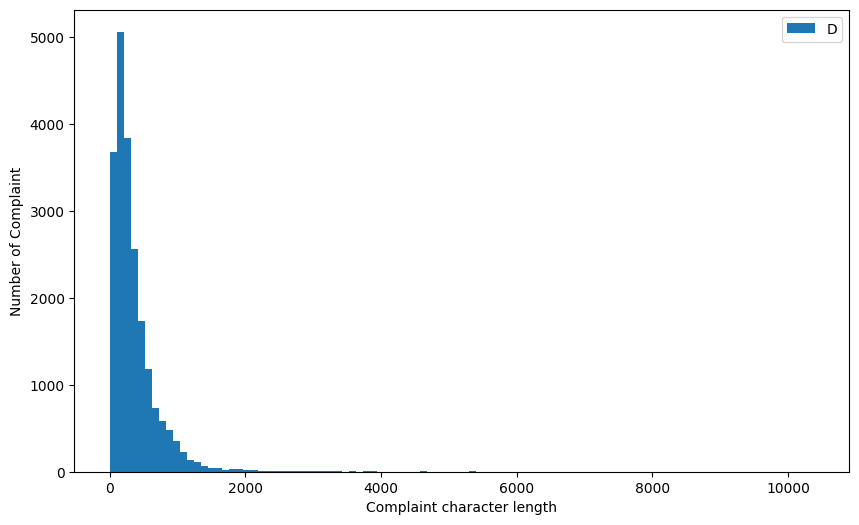

In [15]:
# Write your code here to visualise the data according to the 'Complaint' character length

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


plt.figure(figsize=(10,6))

plt.hist([len(word) for word in df_clean['complaint_POS_removed']], bins=100)

plt.legend("Distribution of Length of strings")
plt.ylabel('Number of Complaint')
plt.xlabel('Complaint character length')
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

In [16]:
!pip install wordcloud

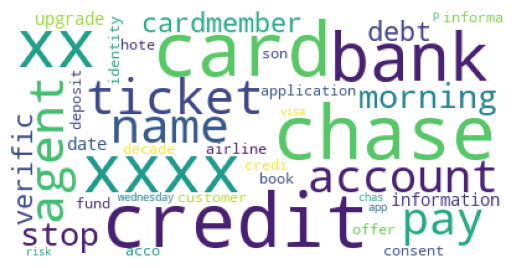

In [17]:
#Using a word cloud find the top 40 words by frequency among all the articles after processing the text

from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stopwords,
                          max_words=40,
                          max_font_size=60,
                          random_state=42
                         ).generate(str(df_clean['complaint_POS_removed']))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In [18]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [19]:
df_clean['Complaint_clean'].head()

1     morning name stop bank cardmember debt verific...
2     i card agent upgrade date agent information or...
10    card xx/xx/ application identity consent credi...
11    book xxxx ticket i offer ticket card i informa...
14    son deposit chase account fund chase bank acco...
Name: Complaint_clean, dtype: object

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [20]:
# Generic function for getting n-gram
def get_top_n_grams(text, n_gram=1, return_records=0):
    vec = CountVectorizer(ngram_range=(n_gram, n_gram), stop_words='english')
    vec.fit(text)
    bow = vec.transform(text)
    sum_of_words = bow.sum(axis=0)
    vocab = vec.vocabulary_
    words_by_frequency = [(sum_of_words[0, index], word) for word, index in vocab.items()]
    sorted_words_by_frequency = sorted(words_by_frequency, key = lambda x:x[0], reverse=True)
    #return_data = pd.DataFrame([(count_values[0, index], word) for word, index in vocab.items()], columns = ('Frequency', '%d-gram' % n_gram ))
    return_data = pd.DataFrame(sorted_words_by_frequency, columns = ('Frequency', '%d-gram' % n_gram ))
    if return_records != 0:
        return_data = return_data[:return_records]
    return return_data


In [21]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean).
unigram_frequent_words = get_top_n_grams(df_clean['Complaint_clean'], n_gram=1, return_records=30)
print("Extracted a frequency with a unigram of shape:", unigram_frequent_words.shape)

Extracted a frequency with a unigram of shape: (30, 2)


In [22]:
#Print the top 10 words in the unigram frequency
unigram_frequent_words.rename(columns={'1-gram': 'unigram'}, inplace=True)
unigram_frequent_words[:10]

,Frequency,unigram
0,61867,xxxx
1,53302,chase
2,41391,account
3,39190,xx
4,32744,credit
5,26709,bank
6,26219,card
7,14014,payment
8,12018,time
9,11969,money


In [23]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean).
bigram_frequent_words = get_top_n_grams(df_clean['Complaint_clean'], n_gram=2, return_records=30)
print("Extracted a frequency with a bigram of shape:", bigram_frequent_words.shape)

Extracted a frequency with a bigram of shape: (30, 2)


In [24]:
#Print the top 10 words in the bigram frequency
bigram_frequent_words.rename(columns={'2-gram': 'bigram'}, inplace=True)
bigram_frequent_words[:10]

,Frequency,bigram
0,19541,xx xx
1,14427,xx xxxx
2,11088,credit card
3,9576,xxxx xxxx
4,3523,chase credit
5,3479,xxxx chase
6,3283,credit report
7,3185,chase account
8,3026,customer service
9,2942,account chase


In [25]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean).

trigram_frequent_words = get_top_n_grams(df_clean['Complaint_clean'], n_gram=3, return_records=30)
print("Extracted a frequency with a trigram of shape:", trigram_frequent_words.shape)

Extracted a frequency with a trigram of shape: (30, 2)


In [26]:
#Print the top 10 words in the trigram frequency
trigram_frequent_words.rename(columns={'3-gram': 'trigram'}, inplace=True)
trigram_frequent_words[:10]

,Frequency,trigram
0,14141,xx xx xxxx
1,2241,xxxx xxxx xxxx
2,1951,chase credit card
3,1906,xxxx xx xx
4,1167,account xx xx
5,1136,xx xxxx chase
6,850,credit card account
7,845,xx xxxx xx
8,819,credit card company
9,806,chase xx xx


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [27]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [28]:
#All masked texts has been removed
df_clean

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card xx/xx/ application identity consent credi...,card xx/xx/ application identity consent credi...
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",book xxxx ticket i offer ticket card i informa...,book ticket i offer ticket card i information...
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...
...,...,...,...,...
78303,after being a chase card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade credit airline hote...,chase card customer decade credit airline hote...
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...","on wednesday , xx / xx / xxxx I call chas , my...",wednesday xx/xx/xxxx i chas visa credit card p...,wednesday xx/xx/ i chas visa credit card provi...
78310,i am not familiar with xxxx pay and did not un...,I be not familiar with xxxx pay and do not und...,i pay risk i bank app chase mobile banking i m...,i pay risk i bank app chase mobile banking i m...
78311,i have had flawless credit for yrs. i've had ...,I have have flawless credit for yrs . I have...,i credit yrs credit chase freedom xxxx balance...,i credit yrs credit chase freedom balance lif...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [29]:
#Write your code here to initialise the TfidfVectorizer

tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [30]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
document_term_matrix = tfidf.fit_transform(df_clean['Complaint_clean'])
document_term_matrix

<21072x6524 sparse matrix of type '<class 'numpy.float64'>'
	with 510452 stored elements in Compressed Sparse Row format>

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [31]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [32]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model =NMF(n_components=num_topics, random_state=40) #write your code here

In [33]:
nmf_model.fit(document_term_matrix)
len(tfidf.get_feature_names())

C:\Program Files\Python39\lib\site-packages\sklearn\decomposition\_nmf.py:312: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



6524

In [34]:
#Print the Top15 words for each of the topics
for index, topic in enumerate(nmf_model.components_):
    print("Top 15 words in the Topic:", (index+1))
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])


Top 15 words in the Topic: 1
['day', 'customer', 'transaction', 'balance', 'fraud', 'business', 'number', 'checking', 'deposit', 'branch', 'chase', 'check', 'money', 'bank', 'account']
Top 15 words in the Topic: 2
['phone', 'statement', 'service', 'purchase', 'customer', 'time', 'dispute', 'company', 'fee', 'fraud', 'balance', 'charge', 'credit', 'chase', 'card']
Top 15 words in the Topic: 3
['response', 'department', 'statement', 'transaction', 'email', 'payment', 'merchant', 'refund', 'date', 'claim', 'charge', 'letter', 'dispute', 'chase', 'xx']
Top 15 words in the Topic: 4
['letter', 'sale', 'bank', 'house', 'foreclosure', 'month', 'rate', 'property', 'time', 'modification', 'home', 'chase', 'mortgage', 'payment', 'loan']
Top 15 words in the Topic: 5
['history', 'payment', 'company', 'theft', 'limit', 'identity', 'account', 'bureaus', 'information', 'reporting', 'debt', 'score', 'inquiry', 'report', 'credit']


In [35]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_results = nmf_model.transform(document_term_matrix)

topic_results[0].round(2)
topic_results[0].argmax()
topic_results.argmax(axis=1)


array([0, 2, 2, ..., 0, 2, 3], dtype=int64)

In [36]:
#Assign the best topic to each of the cmplaints in Topic Column

df_clean['Topic'] = topic_results.argmax(axis=1) #write your code to assign topics to each rows.

In [37]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,2
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card xx/xx/ application identity consent credi...,card xx/xx/ application identity consent credi...,2
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",book xxxx ticket i offer ticket card i informa...,book ticket i offer ticket card i information...,4
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,0


In [38]:
#Print the first 5 Complaint for each of the Topics
df_topic_5=df_clean.groupby('Topic').head(5)
df_topic_5.sort_values('Topic')

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,0
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,0
17,with out notice j.p. morgan chase restricted m...,with out notice j.p . morgan chase restrict my...,j.p. chase account debit card tuesday i branch...,j.p. chase account debit card tuesday i branch...,0
24,mishandling of this account by chase auto and ...,mishandle of this account by chase auto and xx...,mishandling account auto xxxx,mishandling account auto,0
21,"on xxxx xx/xx/, i made a {$.} payment to an on...","on xxxx xx / xx/ , I make a { $ . } payment to...",i payment retailer pay xxxx chase website webs...,i payment retailer pay chase website website ...,0
59,i currently have over xxxx chase ultimate rewa...,I currently have over xxxx chase ultimate rewa...,chase i access chase % bonus chase freedom i p...,chase i access chase % bonus chase freedom i p...,1
52,my roommate was stealing my chase debit card a...,my roommate be steal my chase debit card and d...,roommate chase debit card money account pin ph...,roommate chase debit card money account pin ph...,1
50,i am a senior citizen that has been scammed by...,I be a senior citizen that have be scamme by s...,i citizen xxxx time share nothing refund credi...,i citizen time share nothing refund credit ca...,1
40,"xxxx xxxx a sofa, love seat, table and chairs ...","xxxx xxxx a sofa , love seat , table and chair...",xxxx sofa seat table debit card bank claim fur...,sofa seat table debit card bank claim furnitu...,1
32,my chase amazon card was declined for a cateri...,my chase amazon card be decline for a catering...,chase card catering order i amount chase today...,chase card catering order i amount chase today...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [113]:
#0: Credit card or prepaid card
#   Bank Account services ++
#1: Others
#    Theft/Dispute Reporting +++
#2: Bank Account services ++
#   Credit card or prepaid card?
#3: Mortgage/Loan +++

#4: Credit Card or prepaid card/
#   Others+

#for chk_num in ( 1, 14,  17, 24, 21): # 0 Bank Account services
#for chk_num in (59, 52,  50, 40, 32): # 1  Credit card/prepaid card
#for chk_num in (35, 48,  10, 58, 2): # 2  Theft/Dispute Reporting  -- OTHERS?
#for chk_num in (20, 127, 57, 99, 156): # 3: Mortgage/Loan  ### Theft/Dispute Reporting???
for chk_num in (26, 15,  11, 82, 23): # 4 Others
    print('Topic: ', df_clean.loc[chk_num]['Topic'])
    print(df_clean.loc[chk_num]['complaint_what_happened']) # Credit Card or Prepaid Card
    print('--'*40)

Topic:  4
i have reached out to xxxx several times in attempt to have this fraudulent inquiry removed i was told that i need to call and contact the original creditor that placed this inquiry on my report. i have made several attempts to get chase bank to contact the bureau and remove this inquiry that was not authorized by me. they seem to not be able to get me to the right person to take care of this issue no matter how many attempts i have made nobody seems to understand what i'm talkin about. i want chase bank to have this fraudulent inquiry removed from my credit report before i take legal action. i i have never requested any kind of credit with chase bank or hold any account with them. i have an iquiry from xx/xx/. i want this matter resolved.
--------------------------------------------------------------------------------
Topic:  4
can you please remove inquiry
--------------------------------------------------------------------------------
Topic:  4
on xx/xx/, while trying to b

In [40]:
#Create the dictionary of Topic names and Topics

Topic_names = { 0:'Bank Account services', 1: 'Credit card or prepaid card', 2: 'Theft/Dispute Reporting', 3: 'Mortgage/Loan', 4: 'Others' }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [41]:
#Create the dictionary of Topic names and Topics

#Topic_names = { 0:'Bank Account services', 1: 'Credit card or prepaid card', 2: 'Theft/Dispute Reporting', 3: 'Mortgage/Loan', 4: 'Others' }
Topic_names = { 'Bank Account services': 0, 'Credit card or prepaid card': 1, 'Theft/Dispute Reporting': 2, 'Mortgage/Loan': 3, 'Others' :4 }
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [42]:
df_clean.head()

,complaint_what_happened,complaint_lemmatized,complaint_POS_removed,Complaint_clean,Topic
1,good morning my name is xxxx xxxx and i apprec...,good morning my name be xxxx xxxx and I apprec...,morning name stop bank cardmember debt verific...,morning name stop bank cardmember debt verific...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,I upgrade my xxxx xxxx card in xx / xx/ and be...,i card agent upgrade date agent information or...,i card agent upgrade date agent information or...,2
10,"chase card was reported on xx/xx/. however, fr...","chase card be report on xx / xx/. however , fr...",card xx/xx/ application identity consent credi...,card xx/xx/ application identity consent credi...,2
11,"on xx/xx/, while trying to book a xxxx xxxx ...","on xx / xx/ , while try to book a xxxx xxxx ...",book xxxx ticket i offer ticket card i informa...,book ticket i offer ticket card i information...,4
14,my grand son give me check for {$.} i deposit ...,my grand son give I check for { $ . } I deposi...,son deposit chase account fund chase bank acco...,son deposit chase account fund chase bank acco...,0


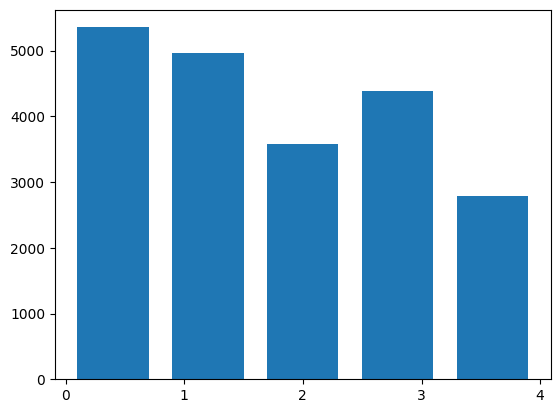

In [96]:
plt.hist(df_clean['Topic'] , bins=5, rwidth=0.75)
plt.xticks(range(0,5))
plt.show()

In [43]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data= df_clean.loc[:, ('complaint_what_happened', 'Topic')]

In [44]:
print(training_data.shape)
training_data


(21072, 2)


,complaint_what_happened,Topic
1,good morning my name is xxxx xxxx and i apprec...,0
2,i upgraded my xxxx xxxx card in xx/xx/ and was...,2
10,"chase card was reported on xx/xx/. however, fr...",2
11,"on xx/xx/, while trying to book a xxxx xxxx ...",4
14,my grand son give me check for {$.} i deposit ...,0
...,...,...
78303,after being a chase card customer for well ove...,4
78309,"on wednesday, xx/xx/xxxx i called chas, my xxx...",2
78310,i am not familiar with xxxx pay and did not un...,0
78311,i have had flawless credit for yrs. i've had ...,2


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [50]:

#Write your code to get the Vector count
vector_counts = CountVectorizer()

X_train_vector_counts = vector_counts.fit_transform(training_data['complaint_what_happened'])
X_train_vector_counts

#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_vector_counts)

In [51]:
X_train_tfidf

<21072x27984 sparse matrix of type '<class 'numpy.float64'>'
	with 2282162 stored elements in Compressed Sparse Row format>

In [52]:
import pickle
pickle.dump(tfidf_transformer, open("tfidf_model.pkl","wb"))

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [74]:
# Write your code here to build any 3 models and evaluate them using the required metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_train_tfidf, training_data.Topic, test_size=0.20, random_state=42)

topic_labels_ordered = ['Bank Account services', 'Credit card or prepaid card', 'Theft/Dispute Reporting', 'Mortgage/Loan', 'Others']

In [100]:
def test_and_print_results(X_test, y_test, model, model_name):
    y_test_predicted = model.predict(X_test)

    print("\n\n%s - Test - Accuracy Score:" %model_name, accuracy_score(y_true= y_test, y_pred=y_test_predicted))

    print("\n\n%s - Test - Confusion Matrix:\n" % model_name)
    print(confusion_matrix(y_true= y_test, y_pred=y_test_predicted))

    print("\n\n%s - Test - Classification Report:\n" % model_name)
    lr_class_report = classification_report(y_true= y_test, y_pred=y_test_predicted, target_names=topic_labels_ordered)
    print(lr_class_report)

#### Logistic Regression

In [72]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(random_state=42, max_iter=30000)
lr_model.fit(X_train, y_train)
#pickle.dump(lr_model, open('LogisticRegression_model.pkl', 'wb'))

In [101]:
test_and_print_results(X_test, y_test, lr_model, 'Logistic Regression')



Logistic Regression - Test - Accuracy Score: 0.8519572953736655


Logistic Regression - Test - Confusion Matrix:

[[989  20  63  14   5]
 [ 33 906  50  13   5]
 [ 94  77 452  54  33]
 [ 15  17  31 758   9]
 [ 18  33  25  15 486]]


Logistic Regression - Test - Classification Report:

                             precision    recall  f1-score   support

      Bank Account services       0.86      0.91      0.88      1091
Credit card or prepaid card       0.86      0.90      0.88      1007
    Theft/Dispute Reporting       0.73      0.64      0.68       710
              Mortgage/Loan       0.89      0.91      0.90       830
                     Others       0.90      0.84      0.87       577

                   accuracy                           0.85      4215
                  macro avg       0.85      0.84      0.84      4215
               weighted avg       0.85      0.85      0.85      4215



### Observations:
- The Logistic regression shows good values at F1 score.
- The Precision and recall scores for Theft/Dispute Reporting seem low when compared with other categories. This could be due to confusing data with respect to other categories as the Theft/Dispute occurs in overlap with any of the other categories...

#### Decision Tree

In [98]:
from sklearn.tree import DecisionTreeClassifier

dt_classifier = DecisionTreeClassifier(random_state=42)
dt_classifier_model = dt_classifier.fit(X_train, y_train)

In [102]:
test_and_print_results(X_test, y_test, dt_classifier_model, 'Decision Tree')



Decision Tree - Test - Accuracy Score: 0.7421115065243179


Decision Tree - Test - Confusion Matrix:

[[818  74 116  51  32]
 [ 69 795  72  26  45]
 [ 94  81 436  69  30]
 [ 45  31  57 668  29]
 [ 36  56  44  30 411]]


Decision Tree - Test - Classification Report:

                             precision    recall  f1-score   support

      Bank Account services       0.77      0.75      0.76      1091
Credit card or prepaid card       0.77      0.79      0.78      1007
    Theft/Dispute Reporting       0.60      0.61      0.61       710
              Mortgage/Loan       0.79      0.80      0.80       830
                     Others       0.75      0.71      0.73       577

                   accuracy                           0.74      4215
                  macro avg       0.74      0.73      0.73      4215
               weighted avg       0.74      0.74      0.74      4215



##### Observations - Decision Trees
- The model doesn't seem to out-perform than the Logistic Regression outcome.

### Random Forests

In [106]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(random_state=42, max_depth=10)
random_forest_model = rfc.fit(X_train, y_train)

In [107]:
test_and_print_results(X_test, y_test, random_forest_model, 'Random Forest')



Random Forest - Test - Accuracy Score: 0.6125741399762752


Random Forest - Test - Confusion Matrix:

[[1003   65    0   21    2]
 [ 198  788    0   16    5]
 [ 315  260   17   97   21]
 [ 137   67    1  623    2]
 [ 121  253    1   51  151]]


Random Forest - Test - Classification Report:

                             precision    recall  f1-score   support

      Bank Account services       0.57      0.92      0.70      1091
Credit card or prepaid card       0.55      0.78      0.65      1007
    Theft/Dispute Reporting       0.89      0.02      0.05       710
              Mortgage/Loan       0.77      0.75      0.76       830
                     Others       0.83      0.26      0.40       577

                   accuracy                           0.61      4215
                  macro avg       0.72      0.55      0.51      4215
               weighted avg       0.69      0.61      0.55      4215



##### Observations - Random forest
- The model doesn't seem to out-perform than the Logistic Regression outcome.
- THe values for f1-score and recall are very low for Theft/Dispute Reporting which means, it has failed to report

# SCRIBBLE

## Test Model
- Input Sentence
- Count Vectorizer
- TF_IDF model
- Supervised Learning Model

In [ ]:
def prepare_model_for_testing(X_test, count_vectorizer, tfidf_model_file, sup_learn_model_file):
    tfidf_model = pickle.load(open(tfidf_model_file, 'rb'))
    supervised_learning_model = pickle.load(open(sup_learn_model_file, 'rb'))

    count_vec_output = count_vectorizer.transform(X_test)
    tfidf_model_output = tfidf_model.transform(count_vec_output)
    predicted_outcome = supervised_learning_model.predict(tfidf_model_output)
    return predicted_outcome